<a href="https://colab.research.google.com/github/IshanKapadia-Data/Walmart-Sales-Forecasting/blob/main/Walmart_Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

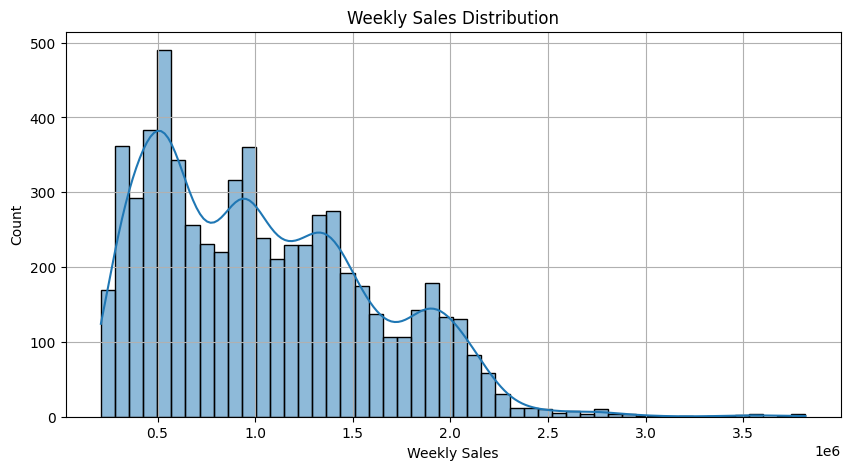

Weekly Sales Summary:
count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64


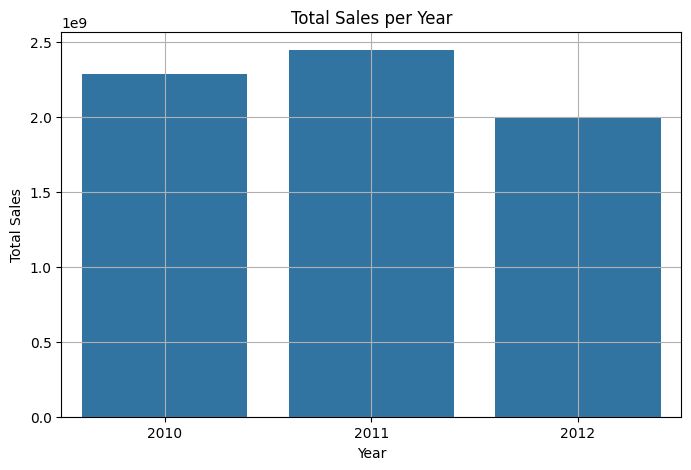


Yearly Total Sales:
   Year  Weekly_Sales
0  2010  2.288886e+09
1  2011  2.448200e+09
2  2012  2.000133e+09


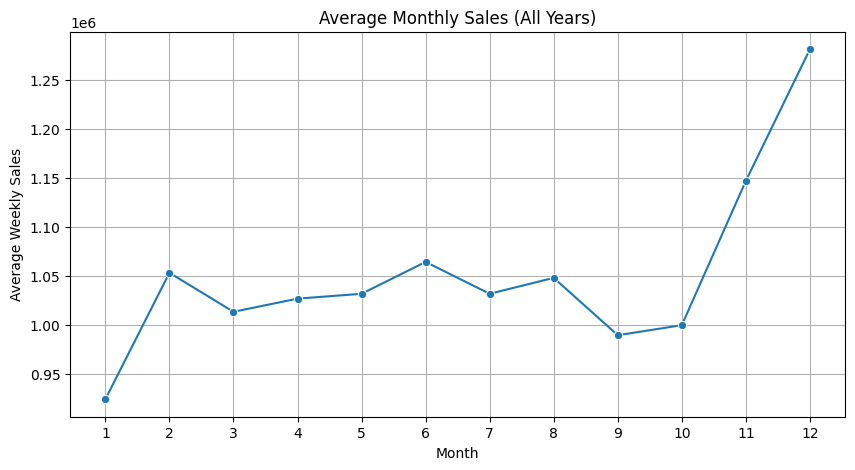


Average Monthly Sales:
    Month  Weekly_Sales
0       1  9.238846e+05
1       2  1.053200e+06
2       3  1.013309e+06
3       4  1.026762e+06
4       5  1.031714e+06
5       6  1.064325e+06
6       7  1.031748e+06
7       8  1.048017e+06
8       9  9.893353e+05
9      10  9.996321e+05
10     11  1.147266e+06
11     12  1.281864e+06


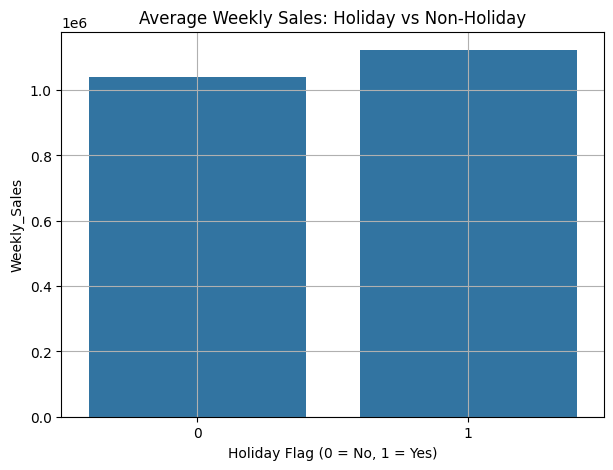


Holiday Sales Comparison:
   Holiday_Flag  Weekly_Sales
0             0  1.041256e+06
1             1  1.122888e+06


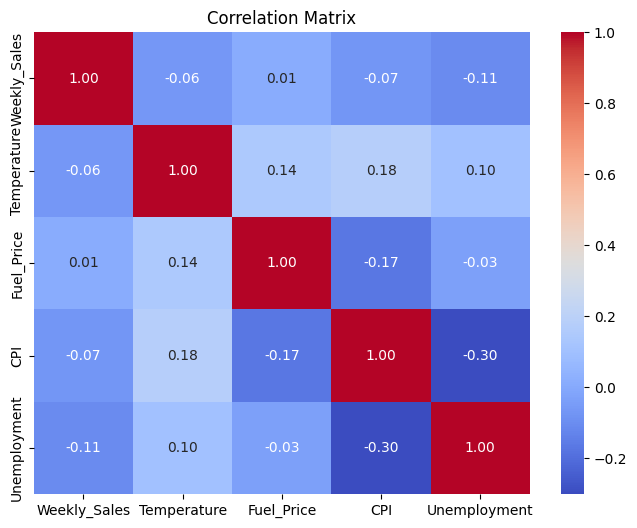


Correlation Matrix:
              Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
Weekly_Sales      1.000000    -0.063810    0.009464 -0.072634     -0.106176
Temperature      -0.063810     1.000000    0.144982  0.176888      0.101158
Fuel_Price        0.009464     0.144982    1.000000 -0.170642     -0.034684
CPI              -0.072634     0.176888   -0.170642  1.000000     -0.302020
Unemployment     -0.106176     0.101158   -0.034684 -0.302020      1.000000


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data
df = pd.read_csv('Walmart.csv')

# Convert Date & Sort
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df = df.sort_values(['Store', 'Date']).reset_index(drop=True)

# 1. Sales Distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['Weekly_Sales'], bins=50, kde=True)
plt.title('Weekly Sales Distribution')
plt.xlabel('Weekly Sales')
plt.grid(True)
plt.show()

print("Weekly Sales Summary:")
print(df['Weekly_Sales'].describe())

# 2. Yearly Sales Trend
yearly_sales = df.groupby('Year')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(8, 5))
sns.barplot(x='Year', y='Weekly_Sales', data=yearly_sales)
plt.title('Total Sales per Year')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

print("\nYearly Total Sales:")
print(yearly_sales)

# 3. Monthly Seasonality
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(10, 5))
sns.lineplot(x='Month', y='Weekly_Sales', data=monthly_sales, marker='o')
plt.title('Average Monthly Sales (All Years)')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.grid(True)
plt.xticks(range(1, 13))
plt.show()

print("\nAverage Monthly Sales:")
print(monthly_sales)

# 4. Holiday Impact
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(7, 5))
sns.barplot(x='Holiday_Flag', y='Weekly_Sales', data=holiday_sales)
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Holiday Flag (0 = No, 1 = Yes)')
plt.grid(True)
plt.show()

print("\nHoliday Sales Comparison:")
print(holiday_sales)

# 5. Correlation Heatmap
corr_matrix = df[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

print("\nCorrelation Matrix:")
print(corr_matrix)


In [2]:
# Copy original DataFrame for feature engineering
df_feat = df.copy()

# Lag Feature
df_feat['Lag_1'] = df_feat.groupby('Store')['Weekly_Sales'].shift(1)

# 4-Week Rolling Mean
df_feat['Rolling_Mean_4'] = df_feat.groupby('Store')['Weekly_Sales'].shift(1).rolling(window=4).mean().reset_index(0, drop=True)

# Drop NA rows (from lag & rolling)
df_feat_clean = df_feat.dropna().reset_index(drop=True)

# Check Final Data
print(df_feat_clean[['Store', 'Date', 'Weekly_Sales', 'Lag_1', 'Rolling_Mean_4']].head())


   Store       Date  Weekly_Sales       Lag_1  Rolling_Mean_4
0      1 2010-03-05    1554806.68  1409727.59    1.576836e+06
1      1 2010-03-12    1439541.59  1554806.68    1.554615e+06
2      1 2010-03-19    1472515.79  1439541.59    1.504011e+06
3      1 2010-03-26    1404429.92  1472515.79    1.469148e+06
4      1 2010-04-02    1594968.28  1404429.92    1.467823e+06


In [3]:
from sklearn.model_selection import train_test_split

# Split Data
train = df_feat_clean[df_feat_clean['Year'] < 2012]
test = df_feat_clean[df_feat_clean['Year'] == 2012]

#  Features & Target
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Holiday_Flag', 'Lag_1', 'Rolling_Mean_4']
target = 'Weekly_Sales'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train Shape: (4320, 7)
Test Shape: (1935, 7)


Test RMSE: 112,267.96
Test MAE: 75,930.76
Test R² Score: 0.9562


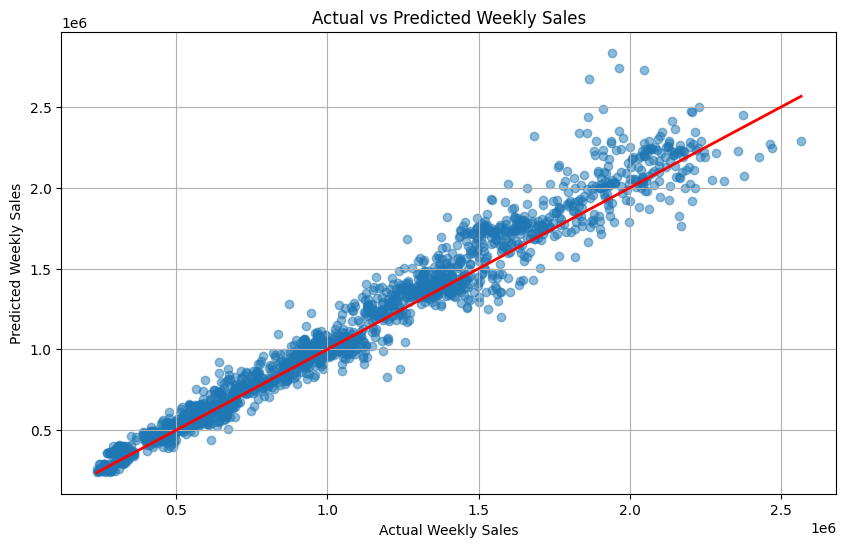

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize & Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=31, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Predict on Test Data
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:,.2f}")
print(f"Test MAE: {mae:,.2f}")
print(f"Test R² Score: {r2:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Actual vs Predicted Weekly Sales')
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.grid(True)
plt.show()


XGBoost Test RMSE: 117,637.82
XGBoost Test MAE: 76,245.53
XGBoost Test R² Score: 0.9519


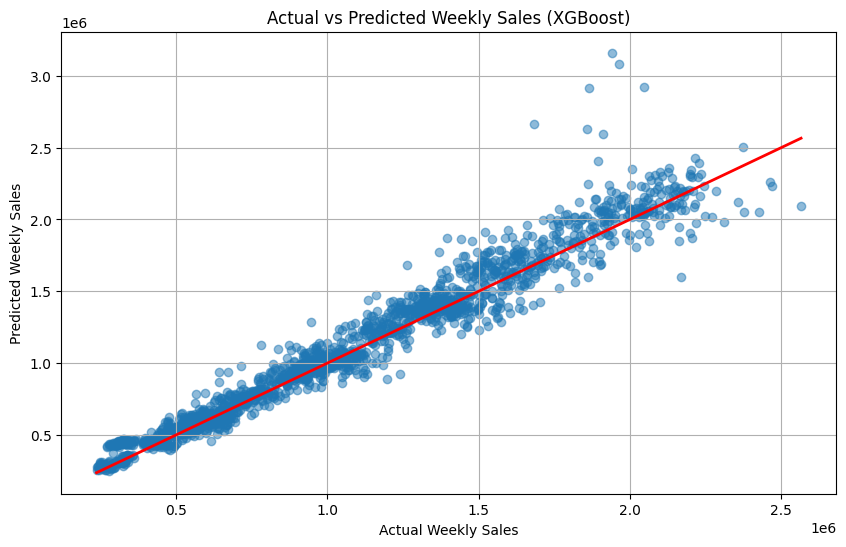

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Prepare DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define Model Parameters
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'seed': 31
}

# Train Model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predictions
y_pred_xgb = xgb_model.predict(dtest)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Test RMSE: {rmse_xgb:,.2f}")
print(f"XGBoost Test MAE: {mae_xgb:,.2f}")
print(f"XGBoost Test R² Score: {r2_xgb:.4f}")

# Actual vs Predicted Plot
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_xgb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.title('Actual vs Predicted Weekly Sales (XGBoost)')
plt.xlabel('Actual Weekly Sales')
plt.ylabel('Predicted Weekly Sales')
plt.grid(True)
plt.show()


In [6]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define Model
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=31)

# Parameter Grid
param_dist = {
    'max_depth': [3, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit
random_search.fit(X_train, y_train)

# Best Parameters
print("Best Parameters Found:", random_search.best_params_)

# Predict with Best Model
best_xgb = random_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test)

# Evaluation
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Tuned XGBoost Test RMSE: {rmse_tuned:,.2f}")
print(f"Tuned XGBoost Test MAE: {mae_tuned:,.2f}")
print(f"Tuned XGBoost Test R² Score: {r2_tuned:.4f}")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters Found: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Tuned XGBoost Test RMSE: 105,052.60
Tuned XGBoost Test MAE: 68,387.70
Tuned XGBoost Test R² Score: 0.9617


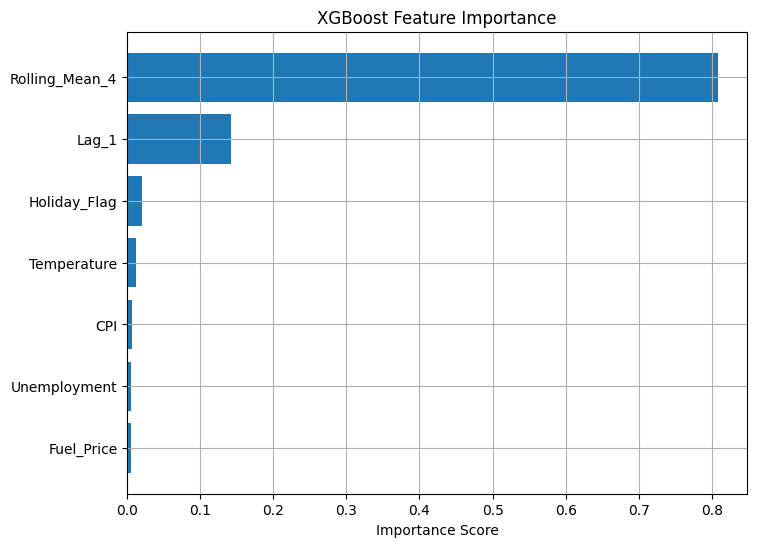

          Feature  Importance
6  Rolling_Mean_4    0.807824
5           Lag_1    0.141733
4    Holiday_Flag    0.020793
0     Temperature    0.012085
2             CPI    0.006518
3    Unemployment    0.005765
1      Fuel_Price    0.005282


In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Get Feature Importances
importances = best_xgb.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(8,6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# Display DataFrame
print(feat_imp_df)